In [0]:
import numpy as np
from keras.datasets import mnist
import matplotlib.pyplot as plt
import imageio
from pathlib import Path

Using TensorFlow backend.


In [0]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()


In [0]:
class GAN:
  def __init__(self, numbers, epochs=100, batch_size=64, input_layer_size_g=100, hidden_layer_size_g=128, hidden_layer_size_d=128, learning_rate=1e-3, decay_rate=1e-4, image_size=28, create_gif=True):
    self.numbers = numbers
    self.epochs = epochs
    self.batch_size = 64
    self.nh_g = hidden_layer_size_g
    self.nx_g = input_layer_size_g
    self.nh_d = hidden_layer_size_d
    self.lr = learning_rate
    self.dr = decay_rate
    self.image_size = image_size
    self.create_gif = create_gif

    self.image_dir = Path('./GAN_sample_image')

    if not self.image_dir.is_dir():
      self.image_dir.mkdir()
    
    self.filenames = []


    self.W0_g = np.random.randn(self.nx_g, self.nh_g)*np.sqrt(2./self.nx_g) 
    self.b0_g = np.zeros((1, self.nh_g))
    self.W1_g = np.random.randn(self.nh_g, self.image_size**2)*np.sqrt(2./self.nh_g)
    self.b1_g = np.zeros((1, self.image_size**2))

    self.W0_d = np.random.randn(self.image_size**2, self.nh_d)*np.sqrt(2./self.image_size**2)
    self.b0_d = np.zeros((1, self.nh_d))
    self.W1_d = np.random.randn(self.nh_d, 1)*np.sqrt(2./self.nh_d)
    self.b1_d = np.zeros((1,1))



In [0]:
def preprocess_data(self, x, y):
  x_train=[]
  y_train=[]

  for i in range(y.shape[0]):
    x_train.append(x[i])
    y_train.append(y[i])

  x_train = np.array(x_train)
  y_train = np.array(y_train)

  num_batches = x_train.shape[0] // self.batch_size
  x_train = x_train[: num_batches * self.batch_size]
  y_train = y_train[: num_batches * self.batch_size]

  x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1]*x_train.shape[2]))
  x_train = (x_train.astype(np.float32) - 127.5)/127.5

  idx = np.random.permutation(len(x_train))
  x_train, y_train = x_train[idx], y_train[idx]

  return x_train, y_train, num_batches

GAN.preprocess_data = preprocess_data


In [0]:
def sigmoid(self, z):
  return 1./(1.+np.exp(-z))

GAN.sigmoid = sigmoid

def dsigmoid(self, z):
  y = self.sigmoid(z)
  return y*(1.-y)

def relu(self, z):
  return np.maximum(z, 0)

def lrelu(self, z, alpha=1e-2):
  return np.maximum(z, z*alpha)

def dlrelu(self, z, alpha=1e-2):
  dz=np.ones_like(z)
  dz[z<0] = alpha
  return dz

def drelu(self, z, alpha):
  dz=np.ones_like(z)
  dz[z<0] = 0
  return dz

def dtanh(self, z):
  return 1 - np.tanh(z)**2


GAN.dsigmoid = dsigmoid
GAN.lrelu = lrelu
GAN.dlrelu = dlrelu
GAN.dtanh = dtanh


In [0]:
def forward_generator(self, z):
  self.z0_g = np.dot(z, self.W0_g) + self.b0_g
  self.a0_g = self.lrelu(self.z0_g, alpha=0)

  self.z1_g = np.dot(self.a0_g, self.W1_g) + self.b1_g
  self.a1_g = np.tanh(self.z1_g)

  return self.z1_g, self.a1_g

GAN.forward_generator = forward_generator

In [0]:
def forward_discriminator(self, x):
  self.z0_d = np.dot(x, self.W0_d) + self.b0_d
  self.a0_d = lrelu(self, self.z0_d)

  self.z1_d = np.dot(self.a0_d, self.W1_d) + self.b1_d
  self.a1_d = self.sigmoid(self.z1_d)

  return self.z1_d, self.a1_d


GAN.forward_discriminator = forward_discriminator

In [0]:
def backward_discriminator(self, x_real, z1_real, a1_real, x_fake, z1_fake, a1_fake):
    # -------- Backprop through Discriminator --------#
    # J_D = np.mean(-np.log(a1_real) - np.log(1 - a1_fake))
    
    # real input gradients -np.log(a1_real)
    da1_real = -1. / (a1_real + 1e-8)  # 64x1

    dz1_real = da1_real * self.dsigmoid(z1_real)  # 64x1
    dW1_real = np.dot(self.a0_d.T, dz1_real)
    db1_real = np.sum(dz1_real, axis=0, keepdims=True)

    da0_real = np.dot(dz1_real, self.W1_d.T)
    dz0_real = da0_real * self.dlrelu(self.z0_d)
    dW0_real = np.dot(x_real.T, dz0_real)
    db0_real = np.sum(dz0_real, axis=0, keepdims=True)

    # fake input gradients -np.log(1 - a1_fake)
    da1_fake = 1. / (1. - a1_fake + 1e-8)

    dz1_fake = da1_fake * self.dsigmoid(z1_fake)
    dW1_fake = np.dot(self.a0_d.T, dz1_fake)
    db1_fake = np.sum(dz1_fake, axis=0, keepdims=True)

    da0_fake = np.dot(dz1_fake, self.W1_d.T)
    dz0_fake = da0_fake * self.dlrelu(self.z0_d, alpha=0)
    dW0_fake = np.dot(x_fake.T, dz0_fake)
    db0_fake = np.sum(dz0_fake, axis=0, keepdims=True)

    # -------- Combine gradients for real & fake images--------#
    dW1 = dW1_real + dW1_fake
    db1 = db1_real + db1_fake

    dW0 = dW0_real + dW0_fake
    db0 = db0_real + db0_fake

    # -------- Update gradients using SGD--------#
    self.W0_d -= self.lr * dW0
    self.b0_d -= self.lr * db0

    self.W1_d -= self.lr * dW1
    self.b1_d -= self.lr * db1
    
GAN.backward_discriminator = backward_discriminator


In [0]:
def backward_generator(self, z, x_fake, z1_fake, a1_fake):
    # -------- Backprop through Discriminator --------#
    # J_D = np.mean(-np.log(a1_real) - np.log(1 - a1_fake))
    
    # fake input gradients -np.log(1 - a1_fake)
    da1_d = -1.0 / (a1_fake + 1e-8)  # 64x1

    dz1_d = da1_d * self.dsigmoid(z1_fake)
    da0_d = np.dot(dz1_d, self.W1_d.T)
    dz0_d = da0_d * self.dlrelu(self.z0_d)
    dx_d = np.dot(dz0_d, self.W0_d.T)

    # -------- Backprop through Generator --------#
    # J_G = np.mean(-np.log(1 - a1_fake))
    dz1_g = dx_d * self.dtanh(self.z1_g)
    dW1_g = np.dot(self.a0_g.T, dz1_g)
    db1_g = np.sum(dz1_g, axis=0, keepdims=True)

    da0_g = np.dot(dz1_g, self.W1_g.T)
    dz0_g = da0_g * self.dlrelu(self.z0_g, alpha=0)
    dW0_g = np.dot(z.T, dz0_g)
    db0_g = np.sum(dz0_g, axis=0, keepdims=True)

    # -------- Update gradients using SGD --------#
    self.W0_g -= self.lr * dW0_g
    self.b0_g -= self.lr * db0_g

    self.W1_g -= self.lr * dW1_g
    self.b1_g -= self.lr * db1_g
    
GAN.backward_generator = backward_generator

In [0]:
def sample_images(self, images, epoch, show):
    images = np.reshape(images, (self.batch_size, self.image_size, self.image_size))
    
    fig = plt.figure(figsize=(4, 4))

    for i in range(16):
        plt.subplot(4, 4, i + 1)
        plt.imshow(images[i] * 127.5 + 127.5, cmap='gray')
        plt.axis('off')

    # saves generated images in the GAN_sample_images folder
    if self.create_gif:
        current_epoch_filename = self.image_dir.joinpath(f"GAN_epoch{epoch}.png")
        self.filenames.append(current_epoch_filename)
        plt.savefig(current_epoch_filename)

    if show == True:
        plt.show()
    else:
        plt.close()

GAN.sample_images = sample_images

In [0]:
def generate_gif(self):
    images = []
    for filename in self.filenames:
        images.append(imageio.imread(filename))
    imageio.mimsave("GAN.gif", images)
    
GAN.generate_gif = generate_gif

In [0]:
def train(self, x, y):
    J_Ds = []  # stores the disciminator losses
    J_Gs = []  # stores the generator losses

    # preprocess input; note that the labels aren't needed
    x_train, _, num_batches = self.preprocess_data(x, y)

    for epoch in range(self.epochs):
        for i in range(num_batches):
            # ------- PREPARE INPUT BATCHES & NOISE -------#
            x_real = x_train[i * self.batch_size: (i + 1) * self.batch_size] # 64x784
            z = np.random.normal(0, 1, size=[self.batch_size, self.nx_g])  # 64x100

            # ------- FORWARD PROPAGATION -------#
            z1_g, x_fake = self.forward_generator(z)

            z1_d_real, a1_d_real = self.forward_discriminator(x_real)
            z1_d_fake, a1_d_fake = self.forward_discriminator(x_fake)

            # ------- CROSS ENTROPY LOSS -------#
            # ver1 : max log(D(x)) + log(1 - D(G(z))) (in original paper)
            # ver2 : min -log(D(x)) min -log(1 - D(G(z))) (implemented here)
            J_D = np.mean(-np.log(a1_d_real) - np.log(1 - a1_d_fake))
            J_Ds.append(J_D)

            # ver1 : minimize log(1 - D(G(z))) (in original paper)
            # ver2 : maximize log(D(G(z)))
            # ver3 : minimize -log(D(G(z))) (implemented here)
            J_G = np.mean(-np.log(a1_d_fake))
            J_Gs.append(J_G)
            # ------- BACKWARD PROPAGATION -------#
            self.backward_discriminator(x_real, z1_d_real, a1_d_real,
                                        x_fake, z1_d_fake, a1_d_fake)
            self.backward_generator(z, x_fake, z1_d_fake, a1_d_fake)

        if epoch % 1 == 0:
            print(f"Epoch:{epoch:}|G loss:{J_G:.4f}|D loss:{J_D:.4f}|D(G(z))avg:{np.mean(a1_d_fake):.4f}|D(x)avg:{np.mean(a1_d_real):.4f}|LR:{self.lr:.6f}")
            self.sample_images(x_fake, epoch, show=True) # display sample images
        else:
            self.sample_images(x_fake, epoch, show=False)

        # reduce learning rate after every epoch
        self.lr = self.lr * (1.0 / (1.0 + self.dr * epoch))

    # generate gif
    if self.create_gif:
        self.generate_gif()
        
    return J_Ds, J_Gs

GAN.train = train

Epoch:0|G loss:0.7206|D loss:1.3241|D(G(z))avg:0.4867|D(x)avg:0.5193|LR:0.001000


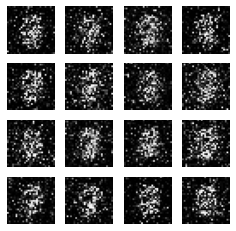

Epoch:1|G loss:0.6781|D loss:1.4173|D(G(z))avg:0.5077|D(x)avg:0.4931|LR:0.001000


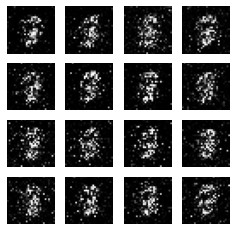

Epoch:2|G loss:0.6586|D loss:1.4509|D(G(z))avg:0.5176|D(x)avg:0.4866|LR:0.001000


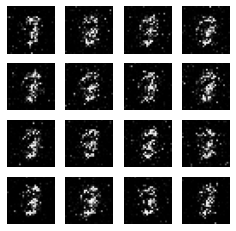

Epoch:3|G loss:0.6530|D loss:1.4608|D(G(z))avg:0.5205|D(x)avg:0.4847|LR:0.001000


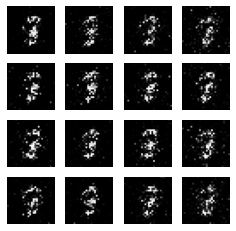

Epoch:4|G loss:0.6525|D loss:1.4603|D(G(z))avg:0.5207|D(x)avg:0.4851|LR:0.000999


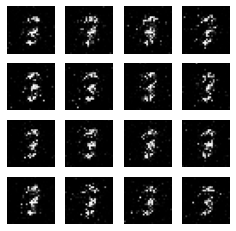

Epoch:5|G loss:0.6534|D loss:1.4540|D(G(z))avg:0.5203|D(x)avg:0.4876|LR:0.000999


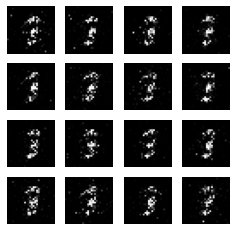

Epoch:6|G loss:0.6640|D loss:1.4314|D(G(z))avg:0.5148|D(x)avg:0.4930|LR:0.000999


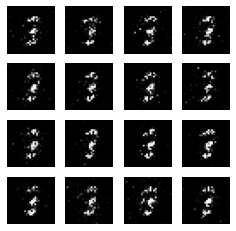

Epoch:7|G loss:0.6788|D loss:1.4019|D(G(z))avg:0.5072|D(x)avg:0.4999|LR:0.000998


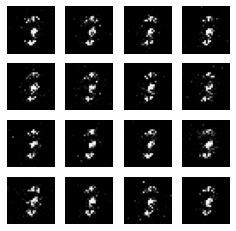

Epoch:8|G loss:0.6986|D loss:1.3636|D(G(z))avg:0.4973|D(x)avg:0.5091|LR:0.000997


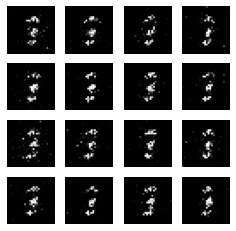

Epoch:9|G loss:0.7205|D loss:1.3215|D(G(z))avg:0.4865|D(x)avg:0.5199|LR:0.000996


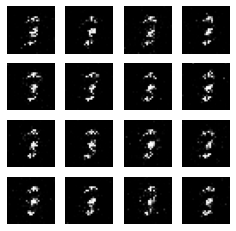

Epoch:10|G loss:1.0562|D loss:1.3216|D(G(z))avg:0.3478|D(x)avg:0.4095|LR:0.000996


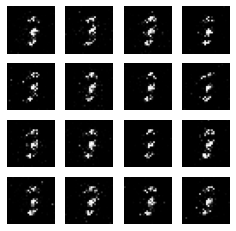

Epoch:11|G loss:0.3116|D loss:1.6188|D(G(z))avg:0.7323|D(x)avg:0.7405|LR:0.000995


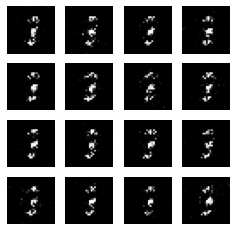

Epoch:12|G loss:1.6275|D loss:1.6726|D(G(z))avg:0.1964|D(x)avg:0.2340|LR:0.000993


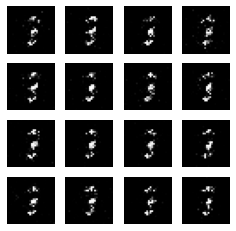

Epoch:13|G loss:0.1641|D loss:2.1282|D(G(z))avg:0.8487|D(x)avg:0.7877|LR:0.000992


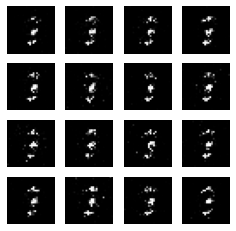

Epoch:14|G loss:1.8298|D loss:1.9668|D(G(z))avg:0.1604|D(x)avg:0.1666|LR:0.000991


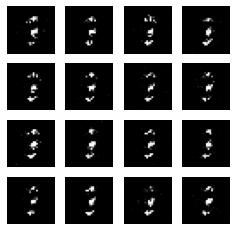

In [0]:
numbers = [6]
model = GAN(numbers, learning_rate = 1e-3, decay_rate = 1e-4, epochs = 15)
J_Ds, J_Gs = model.train(x_train, y_train)

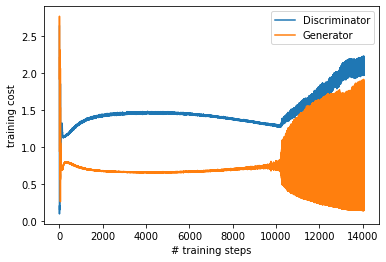

In [0]:
plt.plot([i for i in range(len(J_Ds))], J_Ds)
plt.plot([i for i in range(len(J_Gs))], J_Gs)

plt.xlabel("# training steps")
plt.ylabel("training cost")
plt.legend(['Discriminator', 'Generator'])
plt.show()